### Confused about which neurons are selective for a specific window
Look at time around fb onset first, ANOVA results from: 
- 1.8 to 0s before fb onset
- 0 to 1.5s after fb onset
- whole period from -1.8 to 1.5s around fb onset
- Ask: which neurons show up in first period but not second period? Re-plot region percentages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

In [39]:
sig_level = "99th"
trial_event = "FeedbackOnsetLong"
pre_range = [-1800, 0]
post_range = [0, 1500]


args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.trial_event = trial_event
args.conditions = ["FeatPreferred"]
# args.conditions = ["Response", "Choice"]
args.time_range = pre_range
args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
pre_res = io_utils.read_anova_good_units(args, sig_level)

args.time_range = post_range
post_res = io_utils.read_anova_good_units(args, sig_level)

In [40]:
unit_pos = pd.read_pickle(UNITS_PATH.format(sub="SA"))
region_totals = unit_pos.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="num_total")
region_totals = region_totals[region_totals.num_total > 12]


In [41]:
def region_percentages(res, region_totals):
    by_region = res.groupby("structure_level2").PseudoUnitID.nunique().reset_index(name="selective")
    by_region = pd.merge(by_region, region_totals, on="structure_level2")
    by_region["% units"] = by_region.selective / by_region.num_total * 100
    return by_region

In [42]:
just_pre_res = pre_res[~pre_res.PseudoUnitID.isin(post_res.PseudoUnitID)]
just_post_res = post_res[~post_res.PseudoUnitID.isin(pre_res.PseudoUnitID)]
shared_res = post_res[post_res.PseudoUnitID.isin(pre_res.PseudoUnitID)]

In [43]:
print(f"# units only pre event: {just_pre_res.PseudoUnitID.nunique()}")
print(f"# units only post event: {just_post_res.PseudoUnitID.nunique()}")
print(f"# units shared during both: {shared_res.PseudoUnitID.nunique()}")

# units only pre event: 108
# units only post event: 118
# units shared during both: 46


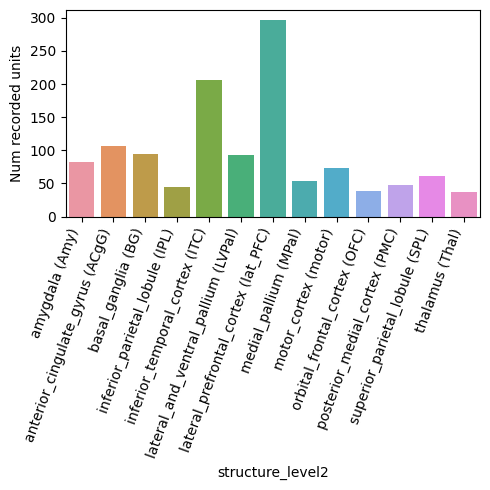

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(region_totals, x="structure_level2", y="num_total", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.set_ylabel("Num recorded units")
fig.tight_layout()

In [45]:
order = region_totals.structure_level2.sort_values().unique()

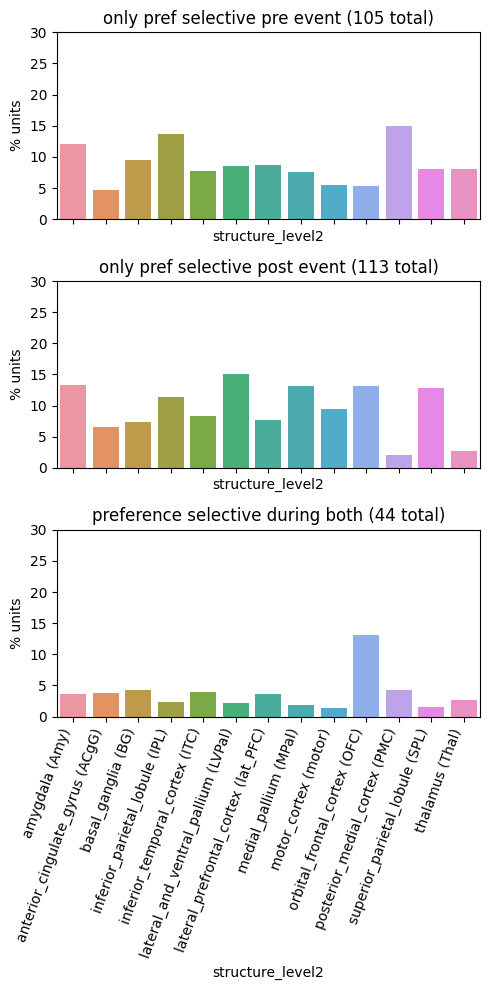

In [46]:
just_pre_by_region = region_percentages(just_pre_res, region_totals)
just_post_by_region = region_percentages(just_post_res, region_totals)
shared_by_region = region_percentages(shared_res, region_totals)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10), sharex=True)
sns.barplot(just_pre_by_region, x="structure_level2", y="% units", order=order, ax=ax1)
ax1.set_title(f"only pref selective pre event ({just_pre_by_region.selective.sum()} total)")
ax1.set_ylim([0, 30])

sns.barplot(just_post_by_region, x="structure_level2", y="% units", order=order, ax=ax2)
ax2.set_title(f"only pref selective post event ({just_post_by_region.selective.sum()} total)")
ax2.set_ylim([0, 30])

sns.barplot(shared_by_region, x="structure_level2", y="% units", order=order, ax=ax3)
ax3.set_title(f"preference selective during both ({shared_by_region.selective.sum()} total)")
ax3.set_ylim([0, 30])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=70, ha='right')
fig.tight_layout()

In [38]:
just_desc_by_region